# Stochastic VI on Probabilistic Count Matrix Factorization

In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
from pCMF.models.pcmf import cavi, svi, gibbs
from pCMF.misc import utils, plot_utils

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from scipy.stats import gamma

import operator

plt.style.use('ggplot')

In [2]:
# Experiment parameters
N = 1000 # number of observations
P = 20 # observation space dimensionality
K = 2 # latent space dimensionality
C = 2 # number of clusters

# Generate data set
z_p = 0.5
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_data(N, P, K, C=C, zero_prob=z_p, 
                                                 eps=eps, return_all=True)

Y_train, Y_test, U_train, U_test, c_train, c_test = train_test_split(Y, U.T, clusters, test_size=0.2, random_state=42)

In [3]:
T = 60.
S = 1.

In [4]:
# Run PCA
pca_U = PCA(n_components=K).fit_transform(Y_train)

# Run Gibbs sampling and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
print('Gibbs:')
inf = gibbs.GibbsSampling(Y_train, alpha, beta, pi)
gibbs_ll = inf.run_gibbs(n_iterations=4000, empirical_bayes=False, mc_samples=10, return_ll=True, sampling_rate=S, max_time=T)
gibbs_U = inf.U # Use the last Gibbs sample of U
# gibbs_U = np.mean(U_samples[10:], axis=0) # Use the sample average after the burn-in period

# Run CAVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
print('CAVI:')
inf = cavi.CoordinateAscentVI(Y_train, alpha, beta, pi)
cavi_ll = inf.run_cavi(n_iterations=4000, empirical_bayes=False, return_ll=True, sampling_rate=S, max_time=T)
cavi_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation

# Run SVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
print('SVI:')
inf = svi.StochasticVI(Y_train, alpha, beta, pi)
svi_ll = inf.run_svi(n_iterations=4000, empirical_bayes=False, minibatch_size=100, return_ll=True, sampling_rate=S, max_time=T)
svi_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation

Gibbs:
Iteration 51/4000. Log-likelihood: 0.194. Elapsed: 60 secondss
CAVI:
Iteration 106/4000. Log-likelihood: 0.128. Elapsed: 60 secondss
SVI:
Iteration 716/4000. Log-likelihood: -0.039. Elapsed: 60 seconds


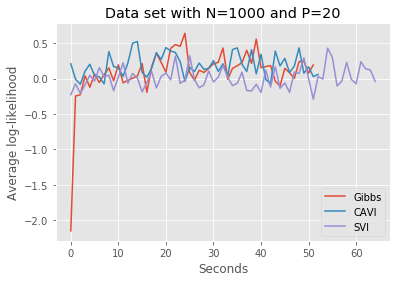

In [5]:
plt.plot(gibbs_ll[1], label='Gibbs')
plt.plot(cavi_ll[1], label='CAVI')
plt.plot(svi_ll[1], label='SVI')
plt.ylabel('Average log-likelihood')
plt.xlabel('Seconds')
plt.title('Data set with N={} and P={}'.format(N, P))
plt.legend()
plt.show()

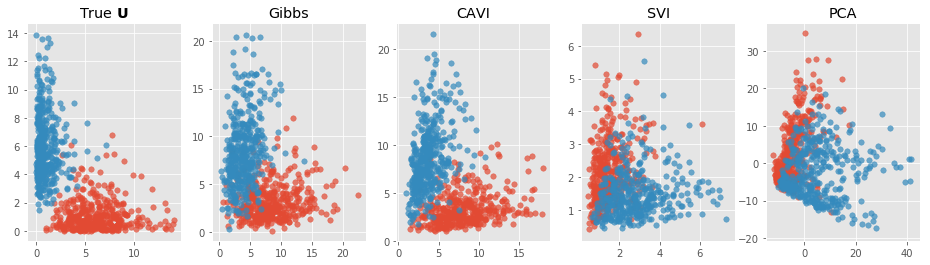

In [6]:
U_list = [U_train, gibbs_U, cavi_U, svi_U, pca_U]
title_list = ['True $\mathbf{U}$', 'Gibbs', 'CAVI', 'SVI', 'PCA']
n_results = len(U_list)

assert len(U_list) == len(title_list)

fig = plt.figure(figsize=(16, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(U_list)):
    ax = plt.subplot(1, n_results, i+1)
    handlers = []
    for c in range(C):
        h = ax.scatter(U_list[i][c_train==c, 0], U_list[i][c_train==c, 1], s=s, alpha=alpha)
        handlers.append(h)
    if labels is not None:
        ax.legend(handlers, labels, scatterpoints=1)
    plt.title(title_list[i])
plt.show()

In [7]:
true_silh = silhouette_score(U_train, c_train)
gibbs_silh = silhouette_score(gibbs_U, c_train)
cavi_silh = silhouette_score(cavi_U, c_train)
svi_silh = silhouette_score(svi_U, c_train)
pca_silh = silhouette_score(pca_U, c_train)

scores = {'CAVI': cavi_silh, 'Gibbs': gibbs_silh, 'PCA': pca_silh, 'SVI': svi_silh}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Silhouette scores (higher is better):')
print('1.\033[1m {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
i = 2
for score_tp in sorted_scores[1:]:
    print('{0}. {1}: {2:.3}'.format(i, score_tp[0], score_tp[1]))
    i += 1
    
print('\nSilhouette of true U:')
print('%0.3f' % true_silh)

Silhouette scores (higher is better):
1. CAVI: 0.423
2. Gibbs: 0.369
3. SVI: 0.202
4. PCA: 0.181

Silhouette of true U:
0.578
